In [1]:
#------------------ LIBRARIES --------------------------#
install.packages("ggplot2")
library(ggplot2)

install.packages("boot")
library(boot)

install.packages("gridExtra")
library(gridExtra)
#-------------------------------------------------------#

also installing the dependencies ‘colorspace’, ‘assertthat’, ‘utf8’, ‘RColorBrewer’, ‘dichromat’, ‘munsell’, ‘labeling’, ‘viridisLite’, ‘cli’, ‘pillar’, ‘rlang’, ‘gtable’, ‘plyr’, ‘reshape2’, ‘scales’, ‘tibble’, ‘lazyeval’




The downloaded binary packages are in
	/var/folders/9s/1kyml98x6f7854mqs56lxrb00000gq/T//RtmpQE1Jle/downloaded_packages

The downloaded binary packages are in
	/var/folders/9s/1kyml98x6f7854mqs56lxrb00000gq/T//RtmpQE1Jle/downloaded_packages

The downloaded binary packages are in
	/var/folders/9s/1kyml98x6f7854mqs56lxrb00000gq/T//RtmpQE1Jle/downloaded_packages


In [2]:
#------------------ NAMES AND LABELS -------------------#
  ### short names for columns
crowd <- 'complexity_crowding'
innercrowd <- 'complexity_innercrowding'
deform <- 'complexity_deformation'
norm_error <- 'normalized_error'
accuracy <- 'ID_accuracy'
accuracy_irrespectiveofID <- 'noID_accuracy'


  ### text labels for charts
lDeform <- 'Deformation'
lincrowd <- 'Inner crowding'
lCrowd <- 'Crowding'
taskA_label <- 'noID'
taskB_label <- 'ID'
#-------------------------------------------------------#

In [5]:
#------------ LOAD AND CHECK DATA ----------------------#
logs <- "staggeredAnimation-xp1-logs.csv"
NB_PARTICIPANTS = 20   ## Our experimental setup, used to check logs have the proper format
NB_REPS = 8
NB_CONDITIONS = 8

data = read.csv(logs, sep="\t", head=TRUE)
data <- data[data$is_practice != 'true',]   ## Filter out practice trials


#### filter by idTrack
taskA <- data[data$is_idTrack == 'false',]
taskB <- data[data$is_idTrack == 'true',]


### Check that data has the expected format ###
if (length(taskA[,1]) != NB_PARTICIPANTS*NB_REPS*NB_CONDITIONS)  
        cat("Warning: wrong number of trials for Condition A")
if (length(taskB[,1]) != NB_PARTICIPANTS*NB_REPS*NB_CONDITIONS)  
        cat("Warning: wrong number of trials for Condition B")
#-------------------------------------------------------#

In [6]:
#--------------- USEFUL FUNCTIONS ----------------------#

##### get subset corresponding to a complexity level 'level' of a measure 'measure'
getSubsetByComplexity <- function(x, measure, level)  {
        result <- x[x[,measure]==level,]

        if (length(result[,1]) != NB_PARTICIPANTS*NB_REPS*NB_CONDITIONS/2)    ### sanity check
                        cat("Warning: wrong number of trials in getSubsetByComplexity")

        return (result)
}
                                        ## Exemple: call getSubsetByComplexity(condA, innercrowd, 'E')



aggregateParticipant <- function(x,measure,f) {
        if (f=="mean")
                return (aggregateMean(x,measure))
        else
                return (aggregateMedian(x,measure))
}

###### get mean per participant
aggregateMean <- function(x, measure) {
        aggdata <- aggregate(x[,measure] ~ participant, data = x, mean)
        return (aggdata)
}


###### get median per participant
aggregateMedian <- function(x, measure) {
        aggdata <- aggregate(x[,measure] ~ participant, data = x, median)
        return (aggdata)
}


##### get global percent of success
getPercent <- function(x, measure) {
        aggdata <- aggregate(x[,measure] ~ participant, data = x, sum)
        aggdata[,2] <- aggdata[,2]/48
        return (aggdata)
}


### get mean of a vector by Measure
getMean <- function(x,measure) {
        mean(x[,measure])
}

### get median of a vector by Measure
getMedian <- function(x,measure) {
        return(median(x[,measure]))
}

### get confidence interval
getCI <- function(x,f) {
        if (f == "mean")
                return(getCIMean(x))
        else    # median
                return(getCIMedian(x))
}

### get Confidence interval (mean)
getCIMean <- function(x) {
        number.measures <- length(x)
        number.samples <- 5000

        sample.mean <- function(x, index) {
                return(mean(x[index]))
        }
        boot.object <- boot(x, sample.mean, R = number.samples)
        confidence.intervals <- quantile(boot.object$t, c(0.025, 0.975))  #the samples are in boot.object$t
        boot.object$t0  # the mean
        return (confidence.intervals)
}

### get Confidence interval (median)
getCIMedian <- function(x) {
        number.measures <- length(x)
        number.samples <- 5000

        sample.median <- function(x, index) {
                return(median(x[index]))
        }
        boot.object <- boot(x, sample.median, R = number.samples)
        confidence.intervals <- quantile(boot.object$t, c(0.025, 0.975))  #the samples are in boot.object$t
        boot.object$t0  # the median
        return (confidence.intervals)
}

## get Lower value of a CI,
# Param: column=<normalized_error, accuracy>, f=<"mean", "median">
getLowerCI <- function(x, f) {
        ci <- getCI(x,f)
        ci <- as.data.frame(ci)
        return(ci[1,1])
}

getUpperCI <- function(x, f) {
        ci <- getCI(x,f)
        ci <- as.data.frame(ci)
        return(ci[2,1])
}
#-------------------------------------------------------#


In [12]:
#--------------- FUNCTIONS FOR PLOTS ----------------------#

 # This function displays the plots  
 # Parameters :
 #      task = <taskA, taskB>
 #      f = <median, mean>
 #      measure = <norm_error, accuracy>
 #      measure_label = lable of the x axis 
 #      colour_palette = colour palette for brewer (1:blue, 4:green, 7:orange)
 #      title = title of the plot
 #      xmin, xmax = xlimits of the plot
 

plotLowHigh <- function(task, f, measure, measure_label, colour_palette, title, xmin, xmax) {
    crowd_L <- aggregateParticipant(getSubsetByComplexity(task,crowd,'L'),measure,f)[,2]
    crowd_H <- aggregateParticipant(getSubsetByComplexity(task,crowd,'H'),measure,f)[,2]
    incrowd_L <- aggregateParticipant(getSubsetByComplexity(task,innercrowd,'L'),measure,f)[,2]
    incrowd_H <- aggregateParticipant(getSubsetByComplexity(task,innercrowd,'H'),measure,f)[,2]
    deform_L <- aggregateParticipant(getSubsetByComplexity(task,deform,'L'),measure,f)[,2]
    deform_H <- aggregateParticipant(getSubsetByComplexity(task,deform,'H'),measure,f)[,2]
    
    L_points <- c(mean(crowd_L), mean(incrowd_L), mean(deform_L))
    if (f=="median") L_points <- c(median(crowd_L), median(incrowd_L), median(deform_L))
    L_lower_CIs <- c(getLowerCI(crowd_L,f), getLowerCI(incrowd_L,f), getLowerCI(deform_L, f))
    L_upper_CIs <- c(getUpperCI(crowd_L,f), getUpperCI(incrowd_L,f), getUpperCI(deform_L, f))
    
    H_points <- c(mean(crowd_H), mean(incrowd_H), mean(deform_H))
    if (f=="median") H_points <- c(median(crowd_H), median(incrowd_H), median(deform_H))
    H_lower_CIs <- c(getLowerCI(crowd_H,f), getLowerCI(incrowd_H,f), getLowerCI(deform_H, f))
    H_upper_CIs <- c(getUpperCI(crowd_H,f), getUpperCI(incrowd_H,f), getUpperCI(deform_H, f))


    dfr <- data.frame(                       # data frame with f and CIs
        x = c(L_points,H_points),
        y = rep(c("Crowding","Inner crowding","Deformation"), 2),
        upper = c(L_upper_CIs, H_upper_CIs),
        lower = c(L_lower_CIs, H_lower_CIs),
        complexity = rep(c("Low","High"), each = 3)
    )
    
    dfr$y_numeric <- c(0.9,1.9,2.9,1.1,2.1,3.1)

    dfr

    p <- ggplot(dfr, aes(x, y_numeric, colour = complexity)) + 
        geom_point(size = 6) +
        geom_errorbarh(aes(xmin=lower, xmax=upper), height = .0, size = 1) +
        scale_colour_brewer(palette=colour_palette) +
        coord_cartesian(xlim = c(xmin, xmax), ylim = c(0.7,3.3)) +
        scale_y_discrete(breaks=c(1,2,3), labels=c("Crowding","Inner crowding","Deformation")) +
        xlab(measure_label) +
        theme_bw() + 
        theme(axis.title.y = element_blank(), axis.line.y = element_blank()) +
        ggtitle(title)
        return (p)
}


plotDifference <- function(task, f, measure, measure_label, title, xmin, xmax) {
    crowd_L <- aggregateParticipant(getSubsetByComplexity(task,crowd,'L'),measure,f)[,2]
    crowd_H <- aggregateParticipant(getSubsetByComplexity(task,crowd,'H'),measure,f)[,2]
    incrowd_L <- aggregateParticipant(getSubsetByComplexity(task,innercrowd,'L'),measure,f)[,2]
    incrowd_H <- aggregateParticipant(getSubsetByComplexity(task,innercrowd,'H'),measure,f)[,2]
    deform_L <- aggregateParticipant(getSubsetByComplexity(task,deform,'L'),measure,f)[,2]
    deform_H <- aggregateParticipant(getSubsetByComplexity(task,deform,'H'),measure,f)[,2]
    if (measure == accuracy || measure == accuracy_irrespectiveofID) {
        crowd_diff <- crowd_L - crowd_H
        incrowd_diff <- incrowd_L - incrowd_H
        deform_diff <- deform_L - deform_H
    }
    else {
        crowd_diff <- crowd_H - crowd_L
        incrowd_diff <- incrowd_H - incrowd_L
        deform_diff <- deform_H - deform_L
    } 
    
    points <- c(mean(crowd_diff), mean(incrowd_diff), mean(deform_diff))
    if (f=="median") L_points <- c(median(crowd_diff), median(incrowd_diff), median(deform_diff))
    lower_CIs <- c(getLowerCI(crowd_diff,f), getLowerCI(incrowd_diff,f), getLowerCI(deform_diff, f))
    upper_CIs <- c(getUpperCI(crowd_diff,f), getUpperCI(incrowd_diff,f), getUpperCI(deform_diff, f))


    dfr <- data.frame(                        # data frame with differences and CIs
        x = points,
        y = c("Crowding","Inner crowding","Deformation"),
        upper = upper_CIs,
        lower = lower_CIs
    )
    
    dfr$y_numeric <- c(1,2,3)

    dfr

    p <- ggplot(dfr, aes(x, y_numeric)) +
        geom_point(size = 6) +
        geom_errorbarh(aes(xmin=lower, xmax=upper), height = .0, size = 1) +
        coord_cartesian(xlim = c(xmin, xmax), ylim = c(0.7,3.3)) +
        scale_y_discrete(breaks=c(1,2,3), labels=c("Crowding","Inner crowding","Deformation")) +
        xlab(measure_label) +
        theme_bw() + 
        theme(axis.title.y = element_blank(), axis.line.y = element_blank()) +
        ggtitle(title)

        return (p)
}


In [16]:
#/------- PLOTS ---------/#
p1 <- plotLowHigh(taskA, "mean", norm_error, "", 1, "noID task - Mean error", 0, 0.4)
p2 <- plotDifference(taskA, "mean", norm_error, "", "noID task - Difference mean error", 0, 0.4)
p3 <- plotLowHigh(taskB, "mean", norm_error, "", 7, "ID task - Mean error", 0, 0.4)
p4 <- plotDifference(taskB, "mean", norm_error, "", "ID task - Difference mean error", 0, 0.4)


p11 <- plotLowHigh(taskA, "mean", accuracy, "", 1, "noID task - Mean accuracy", 0.5, 1)
p12 <- plotDifference(taskA, "mean", accuracy, "", "noID task - Difference mean accuracy", 0, 0.4)
p13 <- plotLowHigh(taskB, "mean", accuracy, "", 7, "ID task - Mean accuracy", 0.5, 1)
p14 <- plotDifference(taskB, "mean", accuracy, "", "ID task - Difference mean accuracy", 0, 0.4)
p15 <- plotLowHigh(taskB, "mean", accuracy_irrespectiveofID, "", 4, "ID task - Mean accuracy (irrespective of ID)", 0.5, 1)
p16 <- plotDifference(taskB, "mean", accuracy_irrespectiveofID, "", "D task - Difference mean accuracy (irrespective of ID)", 0, 0.4)


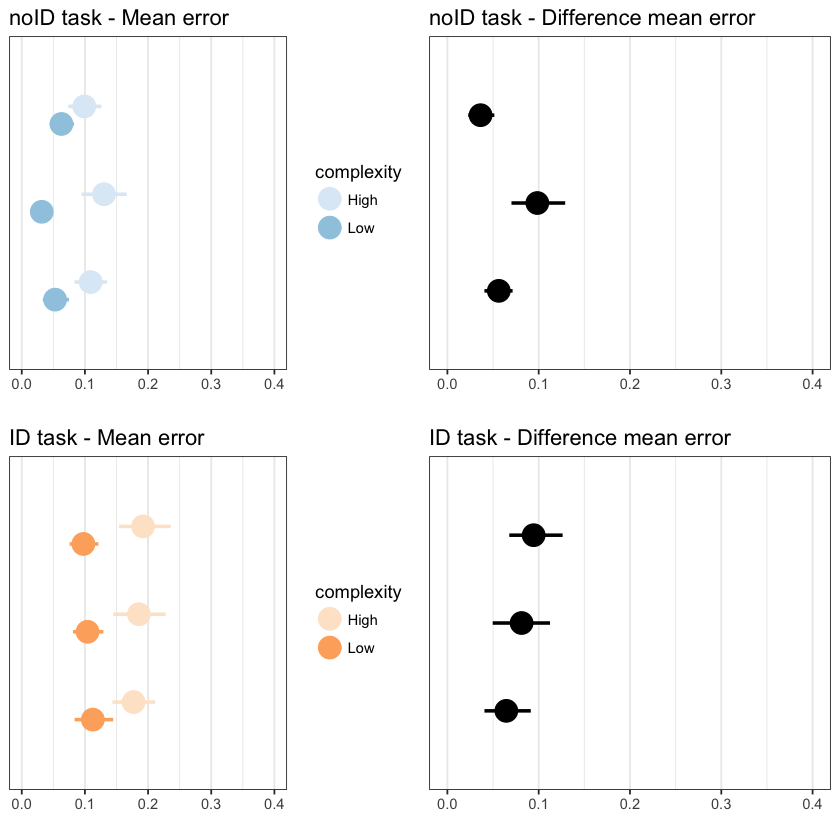

In [18]:
grid.arrange(p1,p2,p3,p4, ncol=2)

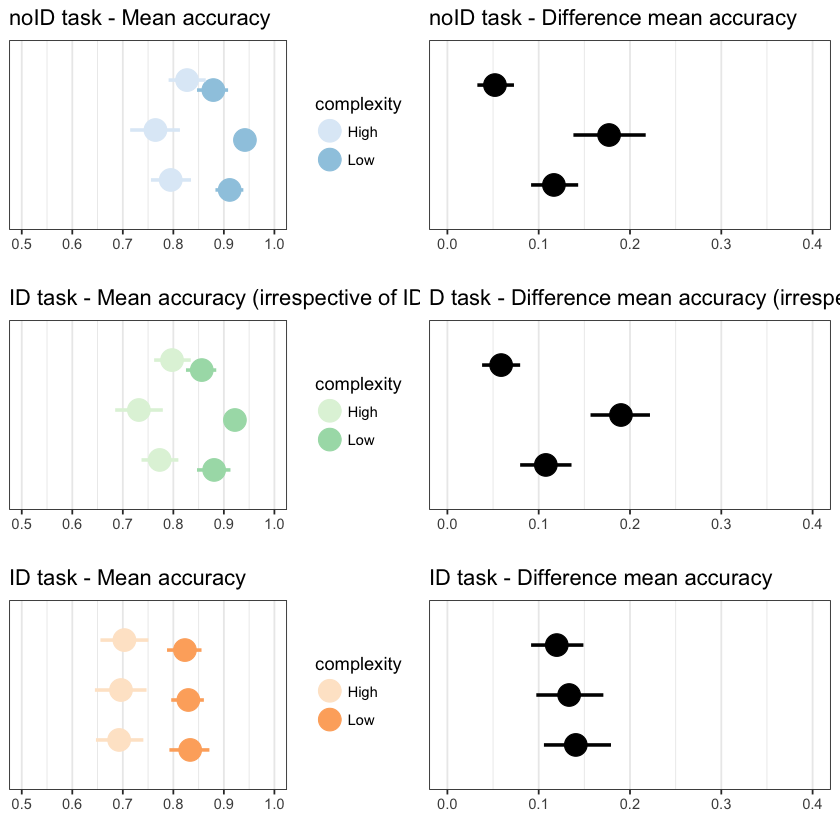

In [19]:
grid.arrange(p11,p12,p15,p16,p13,p14, ncol=2)